In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import cifar100
from keras.datasets import mnist
from zipfile import ZipFile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
np.random.seed(25)
tf.executing_eagerly()

False

In [ ]:
# A function to compute the value of latent space
def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

# The loss function for VAE
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height

    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

# A function to display image sequence
def display_image_sequence(x_start, y_start, x_end, y_end, no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    print(new_images.shape)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2], 3)
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

In [ ]:
# BLOCK ZIP-FILE

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"0B7EVK8r0v71pZjFTYXZWM3FlRnM"})
downloaded.GetContentFile('img_align_celeba.zip')

# Create a ZipFile Object and load sample.zip in it
with ZipFile('img_align_celeba.zip', 'r') as zipObj:
  # Get a list of all archived file names from the zip
  listOfFileNames = zipObj.namelist()
  for fileName in listOfFileNames:
    zipObj.extract(fileName)
print("Done")

Done


In [ ]:
# BLOCK CREATION DE LA BDD
bddImg = []
y_train = []
for a in range(10000):
  randval = random.randint(1, len(listOfFileNames))
  for b in listOfFileNames[randval:randval + 1]:
    y_train.append(b)
    bddImg.append(mpl.image.imread(b))

train_img = []
for i in range(10000-1):
  train_img.append(bddImg[i][0:216,0:176,:])
bddImg = []

train_img = np.array(train_img).astype('float32')
train_img = (train_img[:,:,:,:] - 127)/127
X_train = train_img
train_img = []
y_test = []
for a in range(1000):
  randval = random.randint(1, len(listOfFileNames))
  for b in listOfFileNames[randval:randval + 1]:
    y_test.append(b)
    bddImg.append(mpl.image.imread(b))
listOfFileNames = 0
for i in range(1000-1):
  train_img.append(bddImg[i][0:216,0:176,:])

bddImg = []

train_img = np.array(train_img).astype('float32')
train_img = (train_img[:,:,:,:] - 127)/127

X_test = train_img
train_img = []

In [ ]:
# Loading dataset
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(y_train[0])
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
5
(10000, 28, 28)
(10000,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

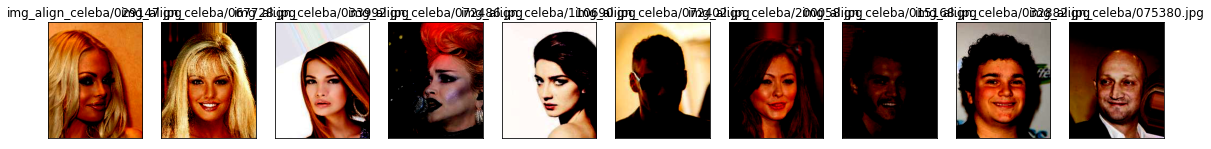

In [ ]:
# Displaying 120th to 129th data
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(20, 7))
counter = 0
for i in range(120, 130):
    axes[counter].set_title(y_train[i])
    axes[counter].imshow(X_train[i], cmap='gray')
    axes[counter].get_xaxis().set_visible(False)
    axes[counter].get_yaxis().set_visible(False)
    counter += 1
plt.show()

In [ ]:
print(X_train.shape)
print(X_test.shape)
# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)

# Defining some variables
img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2    # Dimension of the latent space

(9999, 216, 176, 3)
(999, 216, 176, 3)


In [1]:
# Constructing encoder
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])

# Take the convolution shape to be used in the decoder
conv_shape = K.int_shape(encoder_conv)

# Constructing decoder
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

# Actually build encoder, decoder and the entire VAE
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

# Compile the model using KL loss
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('drive')

#Sauvegarde dans drive des checkpoints

# BLOCK CHECKPOINT
checkpoint_dir = '/content/drive/MyDrive/Vae_Save/Checkpoints_Vae'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(vae=vae)
local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
print("Done!")

Mounted at drive
Done!


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir), options=local_device_option).expect_partial()

In [ ]:
# Training VAE
history = vae.fit(x=X_train_new, y=X_train_new, epochs=20, batch_size=1, validation_data=(X_test_new,X_test_new))

Train on 9999 samples, validate on 999 samples
Epoch 1/20
9999/9999 [==============================] - 471s 47ms/sample - loss: nan - val_loss: nan
Epoch 2/20
9999/9999 [==============================] - 470s 47ms/sample - loss: nan - val_loss: nan
Epoch 3/20
9999/9999 [==============================] - 469s 47ms/sample - loss: nan - val_loss: nan
Epoch 4/20
9999/9999 [==============================] - 467s 47ms/sample - loss: nan - val_loss: nan
Epoch 5/20
9999/9999 [==============================] - 463s 46ms/sample - loss: nan - val_loss: nan
Epoch 6/20
9999/9999 [==============================] - 469s 47ms/sample - loss: nan - val_loss: nan
Epoch 7/20
9999/9999 [==============================] - 458s 46ms/sample - loss: nan - val_loss: nan
Epoch 8/20
9999/9999 [==============================] - 475s 48ms/sample - loss: nan - val_loss: nan
Epoch 9/20
9999/9999 [==============================] - 472s 47ms/sample - loss: nan - val_loss: nan
Epoch 10/20
5604/9999 [===============>.....

KeyboardInterrupt: ignored

In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

'/content/drive/MyDrive/Vae_Save/Checkpoints_Vae/ckpt-2'

(9, 216, 176, 3)


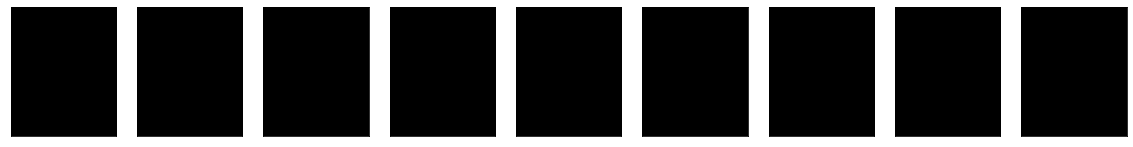

(9, 216, 176, 3)


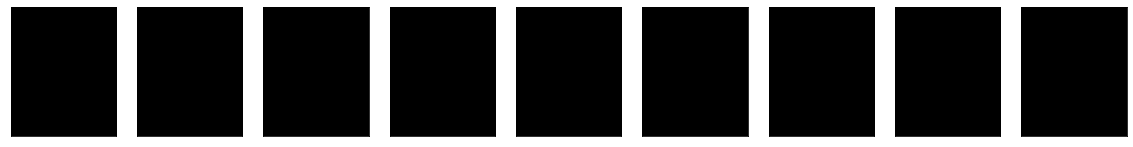

(19, 216, 176, 3)


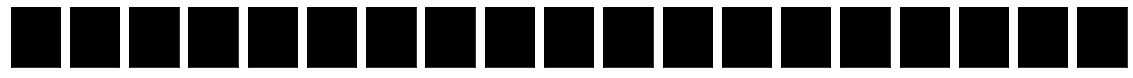

In [ ]:
# Displaying several new images
# Starting point=(0,2), end point=(2,0)
display_image_sequence(0,2,2,0,9)

# Starting point=(-2,1), end point=(0,2)
display_image_sequence(-2,1,0,2,9)

# Starting point=(0,-2), end point=(0,2)
display_image_sequence(0,-2,0,2,19)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


ValueError: ignored

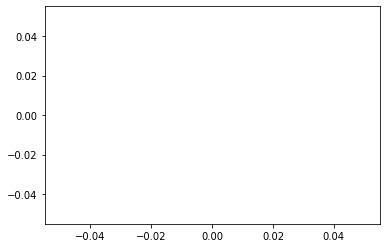

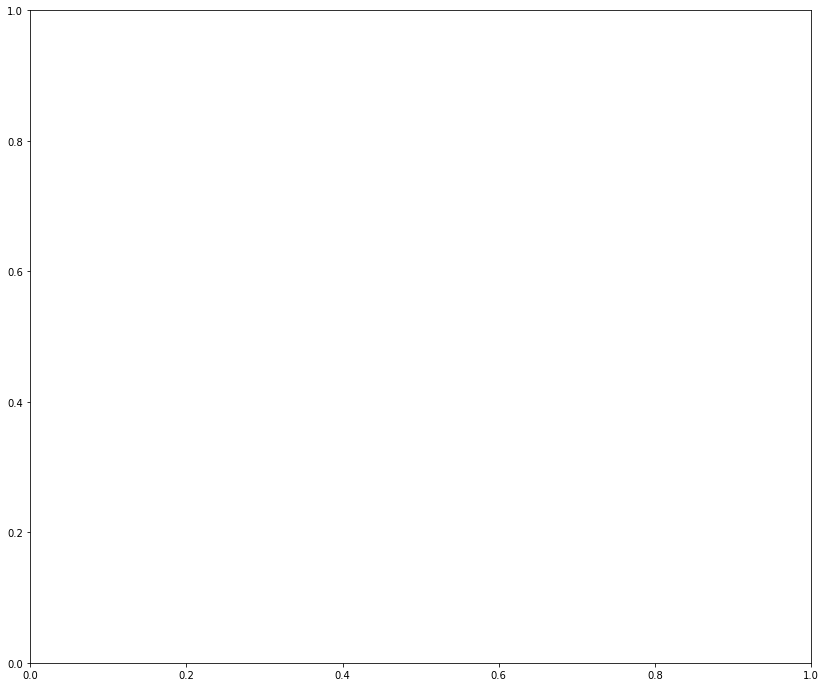

In [ ]:
# Plotting loss value decrease
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Transform images to points in latent space using encoder
encoded = encoder.predict(X_train_new)

# Displaying images in latent space
plt.figure(figsize=(14,12))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.grid()
plt.show()